# Creating population grid

In [20]:
import h3
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import json
import pickle
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray as rxr
from shapely.geometry import Polygon

from src import plotting_functions as plot_func


In [21]:
%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_osmdata.py
%run ../settings/paths.py

h3_res = h3.h3_get_resolution(osm_grid.loc[0,'hex_id'])
print(f"Using H3 resolution {h3_res} for calculating population density")

<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, n)


OSM data loaded successfully!
Using H3 resolution 8 for calculating population density


In [22]:
# LOAD DATA
pop_src_1 = rasterio.open(pop_fp_1)
pop_src_2 = rasterio.open(pop_fp_2)


In [23]:
# MAKE SURE THAT HEXAGONS ARE LARGER THAN PIXELS

avg_area = h3.hex_area(h3_res, unit="m^2")
pixel_area = pop_src_1.res[0] * pop_src_1.res[1]

assert avg_area > pixel_area


In [5]:
# MERGE RASTERS
mosaic, out_trans = merge([pop_src_1, pop_src_2])

out_meta = pop_src_1.meta.copy()

out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": pop_src_1.crs,
    }
)
merged_fp = pop_processed_fp + "merged_pop_raster.tif"
with rasterio.open(merged_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

merged = rasterio.open(merged_fp)


In [6]:
# Load DK boundaries

study_area_poly = gpd.read_file(study_area_fp)
assert study_area_poly.crs == study_crs

study_area_buffer = study_area_poly.buffer(100)

study_area_proj = study_area_buffer.to_crs(merged.crs)
convex = study_area_proj.convex_hull

geo = gpd.GeoDataFrame({"geometry": convex[0]}, index=[0], crs=merged.crs)

coords = [json.loads(geo.to_json())["features"][0]["geometry"]]

# Clip raster to DK extent
clipped, out_transform = mask(merged, shapes=coords, crop=True)

out_meta = merged.meta.copy()

out_meta.update(
    {
        "driver": "GTiff",
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": out_transform,
        "crs": merged.crs,
    }
)
clipped_fp = pop_processed_fp + "clipped_pop_raster.tif"
with rasterio.open(clipped_fp, "w", **out_meta) as dest:
    dest.write(clipped)


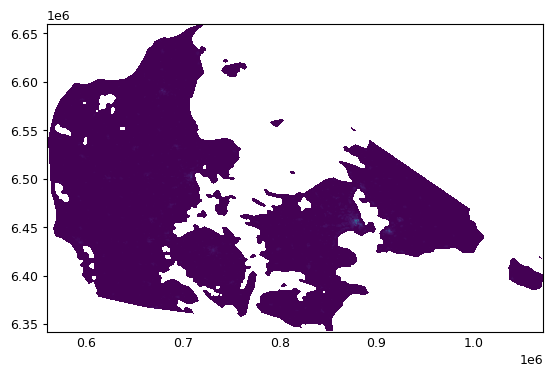

<Axes: >

In [7]:
show(rasterio.open(clipped_fp));


In [8]:
# REPROJECT TO CRS USED BY H3
dst_crs = "EPSG:4326"
proj_fp_wgs84 = pop_processed_fp + "reproj_pop_raster_wgs84.tif"

with rasterio.open(clipped_fp) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {"crs": dst_crs, "transform": transform, "width": width, "height": height}
    )

    with rasterio.open(proj_fp_wgs84, "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear,
            )

test = rasterio.open(proj_fp_wgs84)
assert test.crs.to_string() == "EPSG:4326"

print("Population data has been merged, clipped, and reprojected!")


Population data has been merged, clipped, and reprojected!


In [9]:
# COMBINE WITH H3 DATA

# VECTORIZE
pop_df = (
    rxr.open_rasterio(proj_fp_wgs84)
    .sel(band=1)
    .to_pandas()
    .stack()
    .reset_index()
    .rename(columns={"x": "lng", "y": "lat", 0: "population"})
)

# Ignore no data values
pop_df = pop_df[pop_df.population > -200]

pop_gdf = gpd.GeoDataFrame(pop_df, geometry=gpd.points_from_xy(pop_df.lng, pop_df.lat))

pop_gdf.set_crs("EPSG:4326", inplace=True)

dk_gdf = gpd.GeoDataFrame({"geometry": study_area_proj}, crs=study_area_proj.crs)
dk_gdf.to_crs("EPSG:4326", inplace=True)

pop_gdf = gpd.sjoin(pop_gdf, dk_gdf, predicate="within", how="inner")


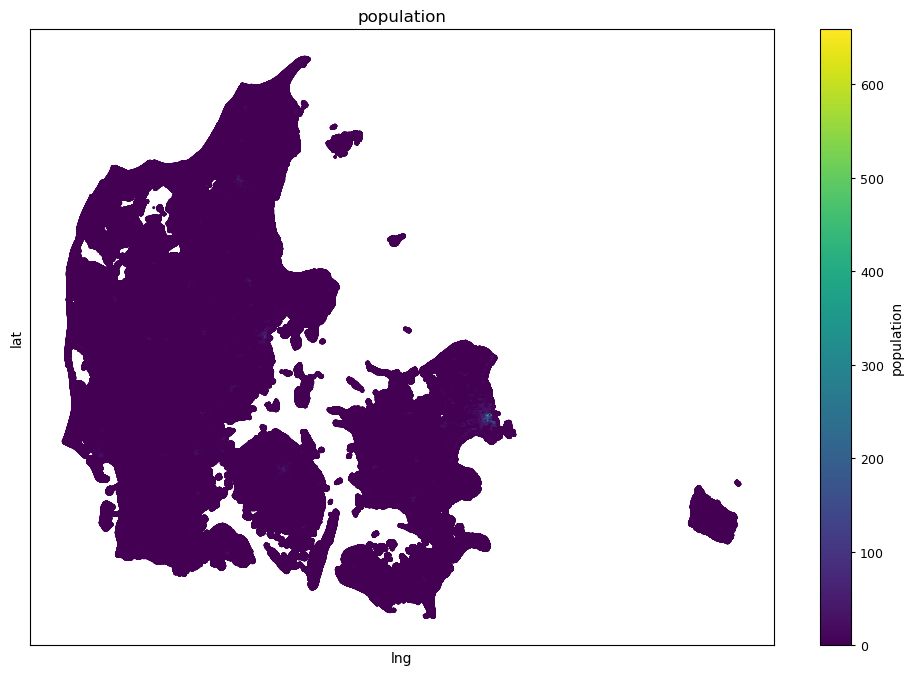

In [10]:
plot_func.plot_scatter(pop_gdf, metric_col="population", marker=".")


In [11]:
# INDEX POPULATION WITH H3

hex_id_col = "hex_id"

pop_gdf[hex_id_col] = pop_gdf.apply(
    lambda row: h3.geo_to_h3(lat=row["lat"], lng=row["lng"], resolution=h3_res), axis=1
)

pop_gdf.head()


,lat,lng,population,geometry,index_right,hex_id
8670,57.756194,10.602487,0.0,POINT (10.60249 57.75619),0,881f24a4c7fffff
8671,57.756194,10.603728,0.0,POINT (10.60373 57.75619),0,881f24a4c7fffff
8672,57.756194,10.604968,0.0,POINT (10.60497 57.75619),0,881f24a4c7fffff
8673,57.756194,10.606209,0.0,POINT (10.60621 57.75619),0,881f24a4c7fffff
8674,57.756194,10.607449,0.0,POINT (10.60745 57.75619),0,881f24a4c7fffff


In [12]:
# Convert to H3 polygons
print(f"Creating hexagons at resolution {h3_res}...")

h3_groups = (
    pop_gdf.groupby(hex_id_col)["population"].sum().to_frame("population").reset_index()
)

h3_groups["lat"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[0])
h3_groups["lng"] = h3_groups[hex_id_col].apply(lambda x: h3.h3_to_geo(x)[1])


h3_groups.head()


Creating hexagons at resolution 8...


,hex_id,population,lat,lng
0,88099269b1fffff,0.000000,56.291590,8.112269
1,88099269b3fffff,0.003862,56.297197,8.121899
2,88099269b5fffff,0.000000,56.285073,8.116069
3,88099269b7fffff,0.008468,56.290681,8.125698
4,88099269bbfffff,0.000000,56.298105,8.108469


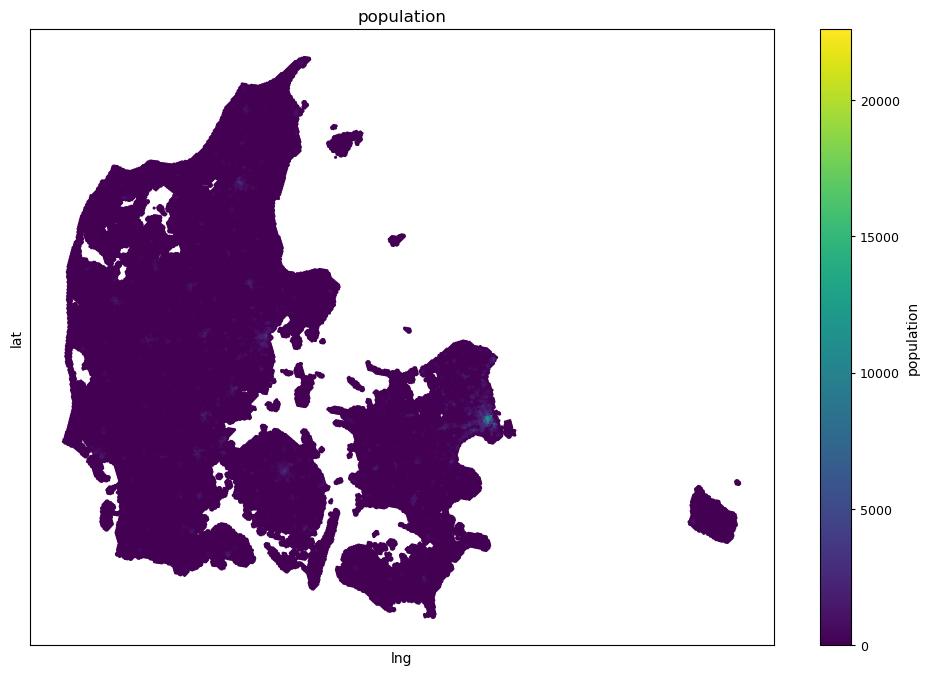

In [13]:
plot_func.plot_scatter(h3_groups, metric_col="population", marker=".")


In [14]:
h3_groups["hex_geometry"] = h3_groups[hex_id_col].apply(
    lambda x: {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=x, geo_json=True)],
    }
)

h3_groups["geometry"] = h3_groups["hex_geometry"].apply(
    lambda x: Polygon(list(x["coordinates"][0]))
)

h3_gdf = gpd.GeoDataFrame(h3_groups, geometry="geometry", crs="EPSG:4326")

h3_gdf.to_crs(study_crs, inplace=True)

h3_gdf.head()


,hex_id,population,lat,lng,hex_geometry,geometry
0,88099269b1fffff,0.000000,56.291590,8.112269,"{'type': 'Polygon', 'coordinates': [((8.106526...","POLYGON ((444700.700 6239167.600, 444574.638 6..."
1,88099269b3fffff,0.003862,56.297197,8.121899,"{'type': 'Polygon', 'coordinates': [((8.116155...","POLYGON ((445304.683 6239784.054, 445178.643 6..."
2,88099269b5fffff,0.000000,56.285073,8.116069,"{'type': 'Polygon', 'coordinates': [((8.110326...","POLYGON ((444926.539 6238439.353, 444800.476 6..."
3,88099269b7fffff,0.008468,56.290681,8.125698,"{'type': 'Polygon', 'coordinates': [((8.119955...","POLYGON ((445530.557 6239055.868, 445404.516 6..."
4,88099269bbfffff,0.000000,56.298105,8.108469,"{'type': 'Polygon', 'coordinates': [((8.102724...","POLYGON ((444474.892 6239895.749, 444348.831 6..."


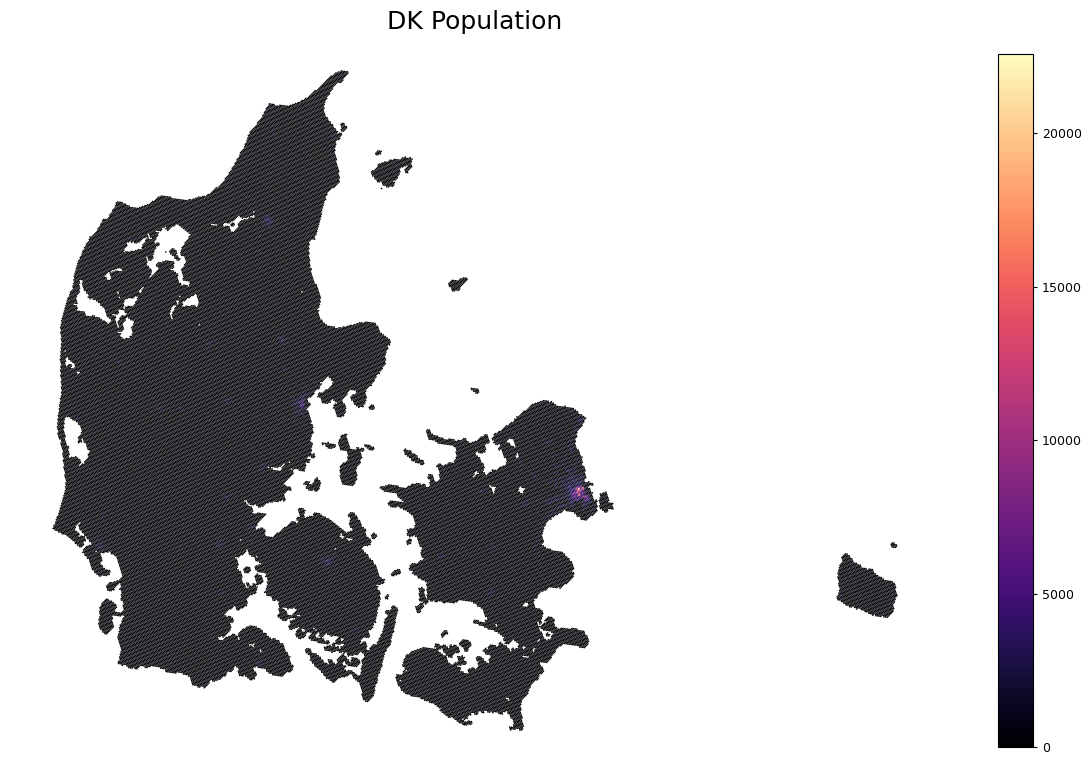

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_axis_off()

h3_gdf.plot(
    ax=ax, column="population", cmap="magma", legend=True, legend_kwds={"shrink": 0.6}
)

plt.title("DK Population", fontsize=18);


In [33]:
# COMPUTE POP DENS
h3_gdf["area_sqkm"] = h3_gdf.area / 1000000
h3_gdf["pop_dens"] = h3_gdf.population / h3_gdf.area_sqkm

h3_gdf.head()

,hex_id,population,lat,lng,hex_geometry,geometry,area_sqkm,pop_dens
0,88099269b1fffff,0.000000,56.291590,8.112269,"{'type': 'Polygon', 'coordinates': [((8.106526...","POLYGON ((444700.700 6239167.600, 444574.638 6...",0.579107,0.000000
1,88099269b3fffff,0.003862,56.297197,8.121899,"{'type': 'Polygon', 'coordinates': [((8.116155...","POLYGON ((445304.683 6239784.054, 445178.643 6...",0.579062,0.006669
2,88099269b5fffff,0.000000,56.285073,8.116069,"{'type': 'Polygon', 'coordinates': [((8.110326...","POLYGON ((444926.539 6238439.353, 444800.476 6...",0.579225,0.000000
3,88099269b7fffff,0.008468,56.290681,8.125698,"{'type': 'Polygon', 'coordinates': [((8.119955...","POLYGON ((445530.557 6239055.868, 445404.516 6...",0.579180,0.014621
4,88099269bbfffff,0.000000,56.298105,8.108469,"{'type': 'Polygon', 'coordinates': [((8.102724...","POLYGON ((444474.892 6239895.749, 444348.831 6...",0.578990,0.000000


In [18]:
# Export data
h3_gdf[["hex_id", "population", "pop_dens", "geometry"]].to_parquet(
    pop_processed_fp + f"h3_pop_{h3_res}_polygons.parquet"
)


In [19]:
h3_gdf[["hex_id", "population", "pop_dens", "geometry"]].to_file(
    pop_processed_fp + f"h3_pop_{h3_res}_polygons.gpkg"
)
